<center>
<img src="logo.png" height="900"> 
</center>


# Arriva, ой то есть ARIMA

Все хотят знать, что же будет дальше с экономикой. Из-за этого люди активно придумывают и строят всякие индикаторы, которые должны помочь понять, когда начнётся кризис. В этом задании вам предстоит проанализировать несколько подобных индикаторов и выяснить правда ли они улучшают прогнозы. 

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns

from matplotlib import pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# 1. Краткая история

__Про ручные индексы__

Экономисты хотят понимать насколько сильно люди верят в прекрасное экономическое будущее. Для этого они проводят социальные опросы: просят оценить насколько люди доверяют банкам, спрашивают есть ли у них инвестиции в ценные бумаги и тп. В итоге ответы на эти вопросы превращаются в индекс потребительских настроений. 

Первым такую штуку начал делать Мичиганский университет. Он спрашивает $500$ потребителей. Каждому задаёт $5$ вопросов, касающихся их финансового положения и мнения о нынешнем состоянии (2 вопроса) и будущем (3 вопроса) экономики. Берется процентная доля респондентов, отметивших улучшение экономических условий, из нее вычитается доля тех, кто заявил, что стало хуже, к полученному числу прибавляется 100. Из ответов на первые 2 вопроса формируется обзор нынешнего экономического положения, из последних $3$-х — индекс потребительских ожиданий. Таким образом, ожидания отвечают примерно за $60\%$ индекса. Расчёт индекса делается дважды в месяц.

В России по аналогичной методике "Левада-центр" начал считать свой индекс потребительских натсроений. На его динамику даже можно посмотреть [у них на сайте.](https://www.levada.ru/indikatory/sotsialno-ekonomicheskie-indikatory/) На самом деле, сейчас социологи считают довольно много подобных индексов. Тот же самый [PMI (индекс деловой активности)](https://ru.wikipedia.org/wiki/Индекс_деловой_активности) - один из возможных вариантов. 

Такие индексы можно пытаться использовать для того, чтобы улучшить прогнозы разных макроэкономических рядов вроде безработицы. И люди активно пытаются это делать. Проблема заключается в том, что нужно тратить много ресурсов на то, чтобы сделать социальный опрос. Плюс социальные опросы можно делать редко. Хочется, чтобы было быстро, дёшево и часто.

__Про автоматические индексы__

Выход есть. Нужно заглянуть в интернет. Любая поисковая система собирает статистику, связанную с запросами пользователей. Более того, частично такая статистика [находится в открытом доступе.](https://trends.google.ru/trends/?geo=RU) Это позволяет собирать информацию о том, чем интересовались люди и на её основе делать какие-то выводы.

Например, в 2013 году Google заявил, что с помощью информации из поисковых запросов о трейлерах, он может с низкой MAPE предсказывать кассовость ленты в первые дни показа. Поисковые запросы используют для предсказания распространения эпидемий гриппа и даже ковида.

По аналогии можно узнать, чем люди интересуются во время кризиса, а дальше попытаться отслеживать такие запросы и понимать, насколько сильно колеблется их обеспокоенность. 

# 2. Данные 

В табличке ниже вам даны несколько индексов потребительских настроений и несколько переменных для прогнозирования: 

- `levada_IPN` - индекс потребительских настроений, который строится на основе социальных опросов Левада-центром. Отражает то, насколько сильно люди доверяют экономике.
- `poiskInd_corr`- индекс поиска, отражает то, насколько сильно люди обеспокоенны тем, что происходит с экономикой. Он построен на основе поисковых запросов. Как именно - для задания неважно, но подробнее об этом можно почитать [в статье про подобные индексы.](https://rjmf.econs.online/2020/4/forecasting-macroeconomic-indicators-news-and-search-queries/)

- `USD` - динамика курса доллара
- `RTRD` - оборот розничной торговли (текущие цены, млрд. рублей)

In [2]:
df = pd.read_csv('data.tsv', sep='\t')
df.set_index('fielddate', inplace=True)
print(df.shape)
df.head()

(194, 4)


,poiskInd_corr,RTRD,levada_IPN,USD
fielddate,,,,
2004-01-01,3.455561,396.5,NaN,28.838795
2004-02-01,9.761241,397.4,NaN,28.514674
2004-03-01,16.271264,433.6,NaN,28.529262
2004-04-01,18.356332,435.6,NaN,28.685632
2004-05-01,10.663158,435.7,NaN,28.989217


выбросим все стоки с пропусками и будем рассматривать индексы на одном и том же временном промежутке. 

In [3]:
df.dropna(inplace=True)

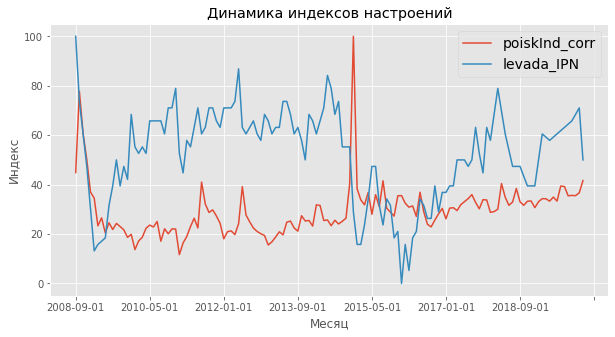

In [4]:
df[['poiskInd_corr', 'levada_IPN']].plot(figsize=(10,5));

plt.title('Динамика индексов настроений');
plt.xlabel("Месяц")
plt.ylabel("Индекс")
plt.legend(fontsize=14);

Видно, что в период кризиса индекс доверия Левады падает. Индекс обеспокоенности, построенный по гуглу, растёт. 

# 3. Предварительный анализ рядов

Проанализируем динамику валютного курса и оборота розничной торговли более детально.

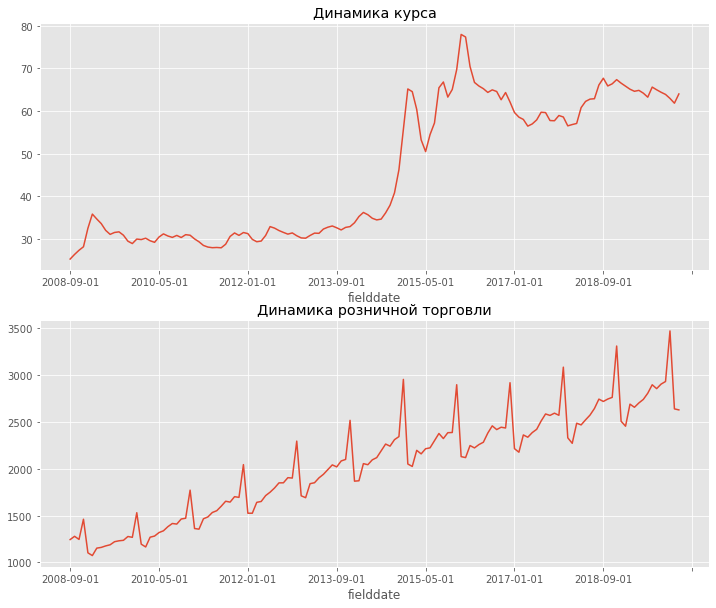

In [5]:
_, axes = plt.subplots(2, 1, figsize=(12,10))

df['USD'].plot(ax=axes[0]);
df['RTRD'].plot(ax=axes[1]);

axes[0].set_title("Динамика курса")
axes[1].set_title("Динамика розничной торговли");

- Видим, что динамика валютного курса нестационарна. У нас есть два математических ожидания. В динамике ряда нет ни тренда ни сезонности.
- В динамике розничной торговли есть тренд и сезонность.  

__[а] Проверьте гипотезу о стационарности рядов с помощью KPSS и ADF тестов на уровне значимости $5\%$. В качестве ответа в переменнык `pval` запишите соотвествующие p-value.__ Обратите внимание, что в динамике розничной торговли есть константа и тренд. В динамике курса есть константа.

In [6]:
from statsmodels.tsa.stattools import adfuller, kpss

pval_usd_kpss = kpss(df['USD'], regression='c')[1]
pval_rtrd_kpss = kpss(df['RTRD'], regression='ct')[1]

pval_usd_adf = adfuller(df['USD'], regression='c')[1]
pval_rtrd_adf = adfuller(df['RTRD'], regression='ct')[1]

C:\Users\Alexey93\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\Alexey93\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [7]:
assert np.abs(pval_usd_kpss - 0.01) < 1e-2
assert np.abs(pval_usd_adf - 0.77) < 1e-2

# несколько похожих скрытых тестов

Оба ряда оказались на уровне значимости $5\%$ нестационарными по всем тестам. 

__[б]__ Возьмите первую разность от валютного курса методом `.diff()`. Для оборота розничной торговли возьмите $12$-ую, сезонную разность. Изобразите динамику разностей на картике. 

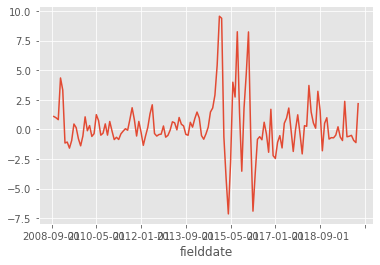

In [8]:
usd_diff = df['USD'].diff()
usd_diff.plot();

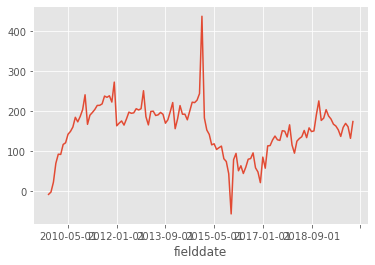

In [9]:
rtrd_diff_12 = df['RTRD'].diff(12)
rtrd_diff_12.plot();

Проверьте ADF-тестом гипотезу о стационарности рядов на уровне значимости $5\%$. В соотвествующие переменные запишите `pvalue` тестов. Обратите внимание, что для курса у нас нет ни константы, ни тренда. Для оборота торговли есть константа.

In [10]:
pval_diff_usd = adfuller(usd_diff.dropna(), regression='nc')[1]
pval_diff_rtrd = adfuller(rtrd_diff_12.dropna(), regression='c')[1]

C:\Users\Alexey93\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:821: FutureWarning: trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.
  warnings.warn(


In [11]:
assert pval_diff_usd < 1e-10

# несколько похожих скрытых тестов

Для обоих рядов гипотеза о наличии единичного корня отвергается. 

> Посмотрим внимательнее на динамику разностей валютного курса. Возникает ощущение, что в конце $2014$ - $2015$ годах дисперися валютного курса была больше, чем в другие периоды времени. Это связано с [валютным кризисом](https://ru.wikipedia.org/wiki/Валютный_кризис_в_России_(2014—2015)) и тем, что с этого момента ЦБ сфокусировался на таргетировании инфляции. Такой разброс в дисперсии будет приводить к тому, что предпосылки ARIMA-модели не будут выполняться. Из-за этого будут портиться доверительные интервалы. Можно стабилизировать дисперсию преобразованием Бокса-Кокса.

__[в]__ Обучите на исходном ряде для курса преобразование Бокса-Кокса, если подзабыли что это за преобразование, пересмотрите лекцию про это из самого первого курса :) Возьмите первые разности, нарисуйте ряд на картинке, стала ли ситуация с дисперсией визуально лучше?

In [12]:
from pmdarima.preprocessing import BoxCoxEndogTransformer
transformer = BoxCoxEndogTransformer().fit(df['USD'])

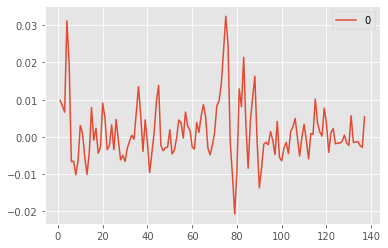

In [13]:
pd.DataFrame(transformer.transform(df['USD'])[0]).diff().plot();

In [14]:
assert np.abs(transformer.lam1_ + 0.447) < 1e-3

# Тут нет скрытых тестов :)

# 4. ARIMA-модель

Разобьём выборку на тренировочную и тестовую, а затем обучим ARIMA-модель. 

1. Параметры `p,q` перебирайте от 0 до 5 включительно, `P,Q` от 1 до 3
2. Параметр `seasonal` выставите в `true` с `m=12`
3. Параметры `max_D, max_d` потавьте равными 2
4. Парааметр `max_order` выставите в 10
5. В поле `information_criterion` выберите для выбора моделя критерий Шварца (`bic`)

In [15]:
import pmdarima as pm

def train_arima(y, test_size=36):
    y_train, y_test = y[:-test_size], y[-test_size:]
    
    arima_model = pm.auto_arima(
        y_train,
        start_p=0, start_q=0,
        max_p=5, max_q=5, 

        seasonal=True, m=12,
        start_P=1, start_Q=1,
        max_P = 3, max_Q = 3,

        max_D=2, max_d=2,
        max_order=10,

        information_criterion='bic',
        trace=True)
    
    return arima_model

Запустите код для обучения. Обратите внимание, что перебираться будут не все модели. Так происходит из-за того, что в опциях модели выставлено `stepwise=True`. Это специальный алгоритм для более быстрого перебора гипер-параметров. Его разработали в 2008 годую. Подробнее [в документации.](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html)

In [16]:
model_rtrd = train_arima(df.RTRD.values)

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(1,1,1)[12]             : BIC=948.930, Time=0.43 sec
 ARIMA(0,1,0)(0,1,0)[12]             : BIC=940.219, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : BIC=939.174, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : BIC=935.187, Time=0.23 sec
 ARIMA(0,1,1)(0,1,0)[12]             : BIC=930.699, Time=0.07 sec
 ARIMA(0,1,1)(1,1,0)[12]             : BIC=935.187, Time=0.19 sec
 ARIMA(0,1,1)(1,1,1)[12]             : BIC=939.675, Time=0.31 sec
 ARIMA(1,1,1)(0,1,0)[12]             : BIC=935.035, Time=0.11 sec
 ARIMA(0,1,2)(0,1,0)[12]             : BIC=934.982, Time=0.11 sec
 ARIMA(1,1,0)(0,1,0)[12]             : BIC=934.686, Time=0.05 sec
 ARIMA(1,1,2)(0,1,0)[12]             : BIC=939.096, Time=0.21 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : BIC=935.127, Time=0.20 sec

Best model:  ARIMA(0,1,1)(0,1,0)[12]          
Total fit time: 2.153 seconds


In [17]:
model_usd = train_arima(df.USD.values)

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : BIC=479.370, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : BIC=482.555, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : BIC=452.802, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : BIC=431.755, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : BIC=479.651, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : BIC=435.913, Time=0.10 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : BIC=436.278, Time=0.28 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : BIC=436.258, Time=0.41 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : BIC=432.773, Time=0.17 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : BIC=440.841, Time=0.74 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : BIC=475.365, Time=0.10 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : BIC=435.696, Time=0.23 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : BIC=435.861, Time=0.20 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : BIC=450.205, Time=0.14 sec
 ARIMA(1,1,2)(0,0,1)[12] intercep

In [18]:
model_rtrd.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  102
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -460.861
Date:                             Thu, 04 Aug 2022   AIC                            925.721
Time:                                     15:52:30   BIC                            930.699
Sample:                                          0   HQIC                           927.728
                                             - 102                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4327      0.046     -9.391      0.000      -0.523      -0.342
sigma2      1838.1501    137.024     13.415      0.000    1569.588    2106.712
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               176.15
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               4.10   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
model_usd.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  102
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -206.813
Date:                            Thu, 04 Aug 2022   AIC                            419.627
Time:                                    15:52:30   BIC                            427.472
Sample:                                         0   HQIC                           422.803
                                            - 102                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.8607      0.047     18.355      0.000       0.769       0.953
ma.S.L12       0.3356      0.123      2.737      0.006       0.095       0.576
sigma2         3.4244      0.315     10.856      0.000       2.806       4.043
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):                58.36
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               8.00   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Запишите в переменные`ans1` и `ans2` порядок $AR$ и $MA$ частей лучшей модели для оборот арозничной торговли. В переменные `ans3` и `ans4` запишите аналогичный результат для валютного курса. 

> __ВАЖНО!!!__ Перед отправкой тетрадки в грейдер на оценивание закомментируйте код, который обучает модели. Оставьте только ответы, записанные в соотвествующие переменные. При выставлении оценки ваш код должен отрабатывать за 30 секунд. Из-за того, что модель обучается довольно долго, полноценный код процедуру тестирования не пройдёт.

In [20]:
ans1 = 0
ans2 = 1
ans3 = 0
ans4 = 1

In [21]:
assert ans1 == 0

# несколько похожих скрытых тестов

Постройте протоколы для диагностики получившихся моделей. __Устно ответьте на вопросы:__ всё ли нормально с остатками? Можно ли использовать эти модели для прогнозирования? А для строительства доверительных интервалов? 

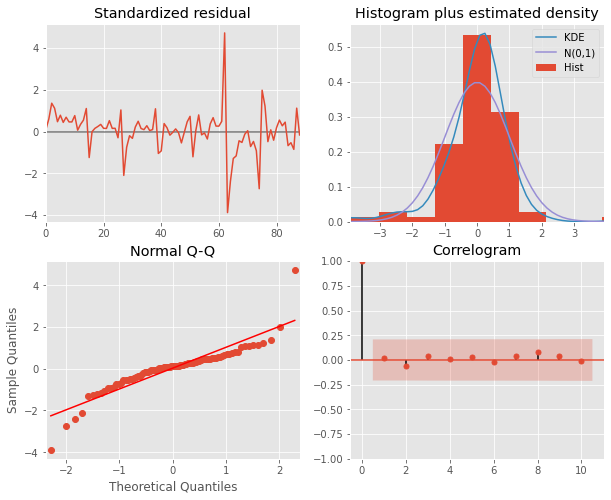

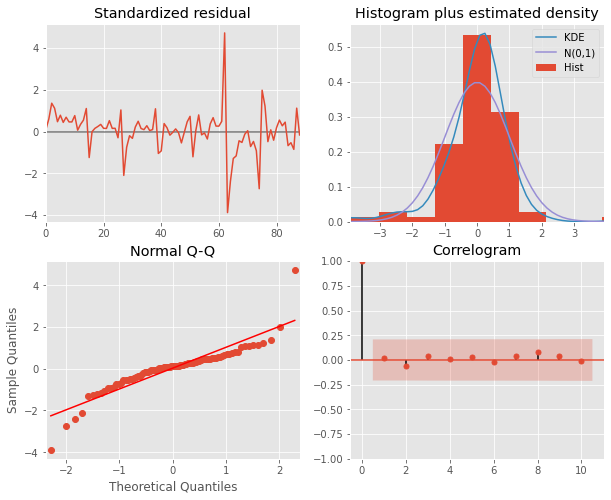

In [22]:
model_rtrd.plot_diagnostics(figsize=(10, 8))

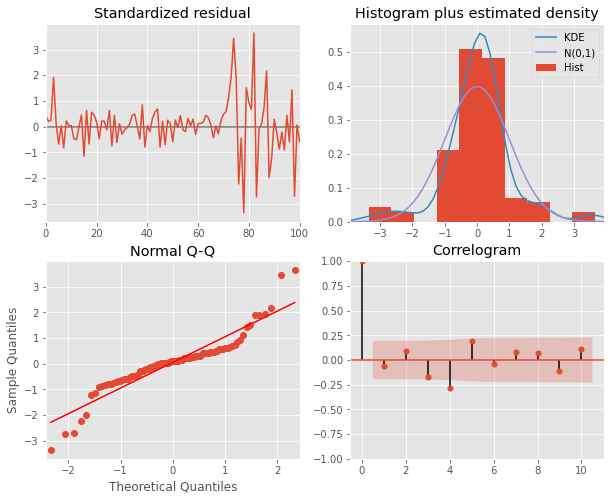

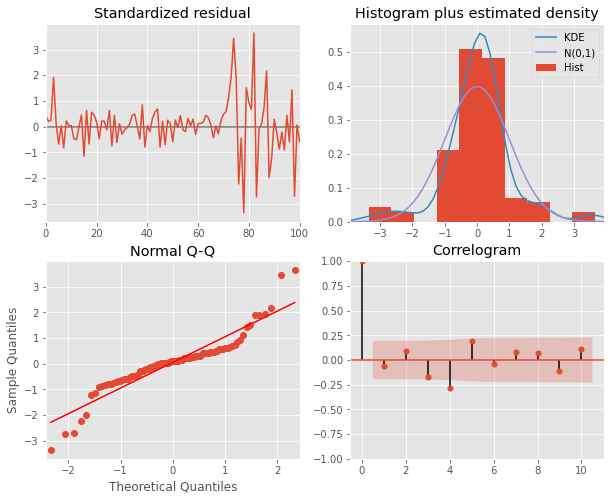

In [23]:
model_usd.plot_diagnostics(figsize=(10, 8))

Внимательно изучите код, написанный ниже. Он строит Leave One Out прогнозы. Сначала обучение идёт на `y_train`. Прогноз строится на один период вперёд. Затем одно наблюдение из `y_test` добавляется в `y_train` и та же модель обучается на новой выборке. Прогноз строится ещё на одно наблюдение вперёд. Так продолжается до тех пор, пока не кончится выборка `y`. 

In [24]:
from pmdarima import model_selection

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def loo_cv(model, y, test_size=36):
    
    y_train, y_test = y[:-test_size], y[-test_size:]

    # метод, который строит прогнозы по заданному внутри правилу
    cv = model_selection.SlidingWindowForecastCV(
        window_size=y_train.size,   # начинаем с трейновой выборки 
        step=1,                     # шаг между фолдами для обучения 
        h=1                         # на сколько шагов вперёд каждый раз строить прогноз
    )

    predicts_noIndex = model_selection.cross_val_predict(
        model, y, # идём получившейся arima_model по y 
        cv = cv,        # по правилам, заданным выше строим прогнозы 
    )
    
    return predicts_noIndex, mae(y_test, predicts_noIndex)

Используя функцию, написсанную выше, постройте прогнозы для курса доллара и оборота розничной торговли. Замерьте качество получившихся прогнозов с помощью метрики MAE. Запишите получившиеся результаты в переменные `mae_usd` и `mae_rtrd`.

In [25]:
mae_usd = loo_cv(model_usd, df['USD'])[1]
mae_usd

1.3861217898198843

In [26]:
mae_rtrd = loo_cv(model_rtrd, df['USD'])[1]
mae_rtrd

2.022398918297201

Изобразите получившиеся прогнозы и исходный ряд на одной картинке. Можно попрбовать использовать для этого функцию `plot_series` из пакет `sktime`. Не забудьте установить его в своё текущее локальное окружение по аналогии с тем, как ммы это сделали для предыдущей домашней работы. 

In [27]:
##

> __ВАЖНО!!!__ Перед отправкой тетрадки в грейдер на оценивание закомментируйте код, который обучает модели. Оставьте только ответы, записанные в соотвествующие переменные. При выставлении оценки ваш код должен отрабатывать за 30 секунд. Из-за того, что модель обучается довольно долго, полноценный код процедуру тестирования не пройдёт.

# 5. ARIMA с экзогенными переменными

Теперь давайте добавим в качестве экзогенной переменной в нашу модель лаги индексов неопределённости. Если бы у нас была модель $ARMA(1,1)$ и мы бы захотели добавить в неё экзогенную переменную $x_{t-1}$, модель выглядела бы так:

$$
y_t = \mu + \beta \cdot  y_{t-1} + \alpha \cdot \varepsilon_{t-1} + \varepsilon_t + \gamma \cdot x_{t-1} 
$$

Экзогенных переменных можно добавить сколько угодно. Для этого у модели есть отдельный параметр. Он на вход принимает матрицу. Для удобства всю процедуру оценки модели завернём в функцию. Внимательно изучите, чем именно эта функция отличается от предыдущей. 

In [28]:

def loo_cv_with_index(model, y, x, test_size=36):
    
    y_train, x_train = y[:-test_size], x[:-test_size]    
    y_test, x_test = y[-test_size:], x[-test_size:]

    cv = model_selection.SlidingWindowForecastCV(
        window_size=y_train.size, 
        step=1, 
        h=1
    )

    predicts = model_selection.cross_val_predict(
        model, y,
        exogenous = np.array([x]).T,
        cv=cv
    )
    
    return predicts, mae(y_test, predicts)

Лучшую модель мы подобрали. Давайте попробуем добавить в неё в качестве экзогенной переменной наши индексы неопределённости. Это поможет нам увидеть, правда ли эти индексы улучшают качество прогнозов.

### Оборот розничной торговли

Добавим текущее значение индекса. Если качество прогноза вырасте, это означает, что текущий индекс содержит в себе информацию о том, что произошло в экономике прямо сейчас. Для прогнозирования это бесполезно, но показывает насколько сильно наш индекс может объяснить ситуацию в экономике.

> Код ниже может работать довольно долго. 

In [29]:
y = df.RTRD.values
x = df.levada_IPN.values

predicts_levada_rtrd, mae_rtrd_2 = loo_cv_with_index(model_rtrd, y, x)

In [30]:
y = df.RTRD.values
x = df.poiskInd_corr.values

predicts_poisk_rtrd, mae_rtrd_3 = loo_cv_with_index(model_rtrd, y, x)

In [31]:
print(f'Оригинальная модель: {mae_rtrd}')
print(f'Модель с индексом Левады: {mae_rtrd_2}')
print(f'Модель с индексом поиска: {mae_rtrd_3}')

Оригинальная модель: 2.022398918297201
Модель с индексом Левады: 17.40324632204267
Модель с индексом поиска: 21.03537048446363


Индекс Левады улучшил прогноз оборота розничной торговли. Индекс поиска ухудшил. Попробуем посмотреть, получится ли у нас предсказывать по текущему значению индекса будущее значение оборота розничной торговли.

In [32]:
y = df.RTRD.values[1:]
x = df.levada_IPN.shift(1).values[1:] # shift это сдвиг на 1 вперёд, мы же предсказываем лагом

predicts_levada_rtrd, mae_rtrd_2 = loo_cv_with_index(model_rtrd, y, x)

In [33]:
y = df.RTRD.values[1:]
x = df.poiskInd_corr.shift(1).values[1:] # shift это сдвиг на 1 вперёд, мы же предсказываем лагом

predicts_poisk_rtrd, mae_rtrd_3 = loo_cv_with_index(model_rtrd, y, x)

In [34]:
print(f'Оригинальная модель: {mae_rtrd}')
print(f'Модель с индексом Левады: {mae_rtrd_2}')
print(f'Модель с индексом поиска: {mae_rtrd_3}')

Оригинальная модель: 2.022398918297201
Модель с индексом Левады: 21.53266510803765
Модель с индексом поиска: 19.08477739065913


Видно, что оба индекса ухудшили прогнозы :( 

###  Курс валюты 

Проделаем такую же операцию с валютным курсом. 

In [35]:
y = df.USD.values
x = df.levada_IPN.values

predicts_levada_usd, mae_usd_2 = loo_cv_with_index(model_usd, y, x)

In [36]:
y = df.USD.values
x = df.poiskInd_corr.values

predicts_poisk_usd, mae_usd_3 = loo_cv_with_index(model_usd, y, x)

In [37]:
print(f'Оригинальная модель: {mae_usd}')
print(f'Модель с индексом Левады: {mae_usd_2}')
print(f'Модель с индексом поиска: {mae_usd_3}')

Оригинальная модель: 1.3861217898198843
Модель с индексом Левады: 1.3393446629344217
Модель с индексом поиска: 1.3662353224550747


Видго, что оба индекса содержат информацию о том, какие значения курс принял прямо сейчас. Попробуем посмотреть, можно ли прогнозировать курс с помощью запаздывания лучше, чем обычной ARIMA. 

In [38]:
y = df.USD.values[1:]
x = df.levada_IPN.shift(1).values[1:] # shift это сдвиг на 1 вперёд, мы же предсказываем лагом

predicts_levada_usd, mae_usd_2 = loo_cv_with_index(model_usd, y, x)

In [39]:
y = df.USD.values[1:]
x = df.poiskInd_corr.shift(1).values[1:] # shift это сдвиг на 1 вперёд, мы же предсказываем лагом

predicts_poisk_usd, mae_usd_3 = loo_cv_with_index(model_usd, y, x)

In [40]:
print(f'Оригинальная модель: {mae_usd}')
print(f'Модель с индексом Левады: {mae_usd_2}')
print(f'Модель с индексом поиска: {mae_usd_3}')

Оригинальная модель: 1.3861217898198843
Модель с индексом Левады: 1.3870817618077247
Модель с индексом поиска: 1.3590032018755567


Видно, что индекс поиска улучшил прогнозы. Индекс Левады не привёл к улучшению. 

__Выводы:__ индексы поиска и Левады содержут информацию о том, что в данный момент происходит в экономике. Их текущее значение помогает предсказать, что происходит прямо сейчас в экономике. На практике это бесполезно. Мы хотим по вчерашнему значению индекса спрогнозировать, что произойдет завтра. Видно, что это можно сделать для курса доллара с помощью индекса поиска.

Обратите внимание, что данные у нас месячные. Если бы частота данных была бы повыше, эффект от добавления индексов в модели мог бы быть сильнее. Но это требует отдельного исследования :) 

Попробуйте, по аналогии с тем, что было сделано выше, добавить в модель в качестве экзогенных переменных сразу оба индекса. Насколько сильно это улучшает прогноз? 

In [41]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

> __ВАЖНО!!!__ Перед отправкой тетрадки в грейдер на оценивание закомментируйте код, который обучает модели. Оставьте только ответы, записанные в соотвествующие переменные. При выставлении оценки ваш код должен отрабатывать за 30 секунд. Из-за того, что модель обучается довольно долго, полноценный код процедуру тестирования не пройдёт.

# Бонусный трэк:

- Попробуйте взять в качестве дополнительных экзогенных переменных сразу же и индекс поиска и индекс Левада-центра. 
- Выше мы сказали, что у валютного курса не самая стабильная дисперсия. Соберите пайплайн, в котором первым шагом метод Бокса-Кокса будет стабилизировать дисперсию. Обучите обе модели и посмотрите что происходит с качеством прогнозов. 
- По картинкам для диагностики модели видно, что в данных есть выброс. Можно попробовать изолировать его с помощью экзогенной дамми-переменной, если хочется добиться идеального выполнения предпосылок. 
- Если вас заинтересовали индексы неопределённости, можно посмотреть [статью автора курса про такие индексы бывают с кучей ссылок и кодом](https://github.com/FUlyankin/uncertainty_index)

In [42]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you